# Лабораторная работа №5. Выбор признаков

**Работа выполнена**: Бактурин Савелий Филиппович M33331

**Преподаватель**: TBA.

## Инициализация

### Импорт библиотек

In [133]:
import warnings

In [134]:
warnings.filterwarnings("ignore")

In [135]:
import optuna
import tqdm
import sklearn
import sklearn.neighbors
import sklearn.metrics
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.tree
import sklearn.ensemble
import pandas
import numpy
import numpy.linalg
import matplotlib
import matplotlib.pyplot
import seaborn
import collections
import random
import copy
import math
import itertools
import scipy
import scipy.stats
from typing import List, Callable, Union, Tuple, Mapping, Set
from abc import ABC, abstractmethod

In [136]:
matplotlib.rcParams.update({'font.size': 14})

### Константные значения

In [137]:
from config import *

## Отчёт

### Набор данных

#### Загрузка данных

In [138]:
sms = pandas.read_csv(DATA_FILENAME, delimiter = DATA_DELIMITER)

In [139]:
sms.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [140]:
sms.tail()

,class,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


#### Обзор

##### Вспомогательные функции

In [141]:
def draw_feature_countable(feature: str, data: pandas.DataFrame):
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.grid(True)
	seaborn.countplot(data = data, y = feature, order = data[feature].value_counts().index)
	matplotlib.pyplot.xlabel("N")
	matplotlib.pyplot.ylabel(feature)

##### Классы сообщений

In [142]:
print("Classes:", set(sms["class"].tolist()))

Classes: {'spam', 'ham'}


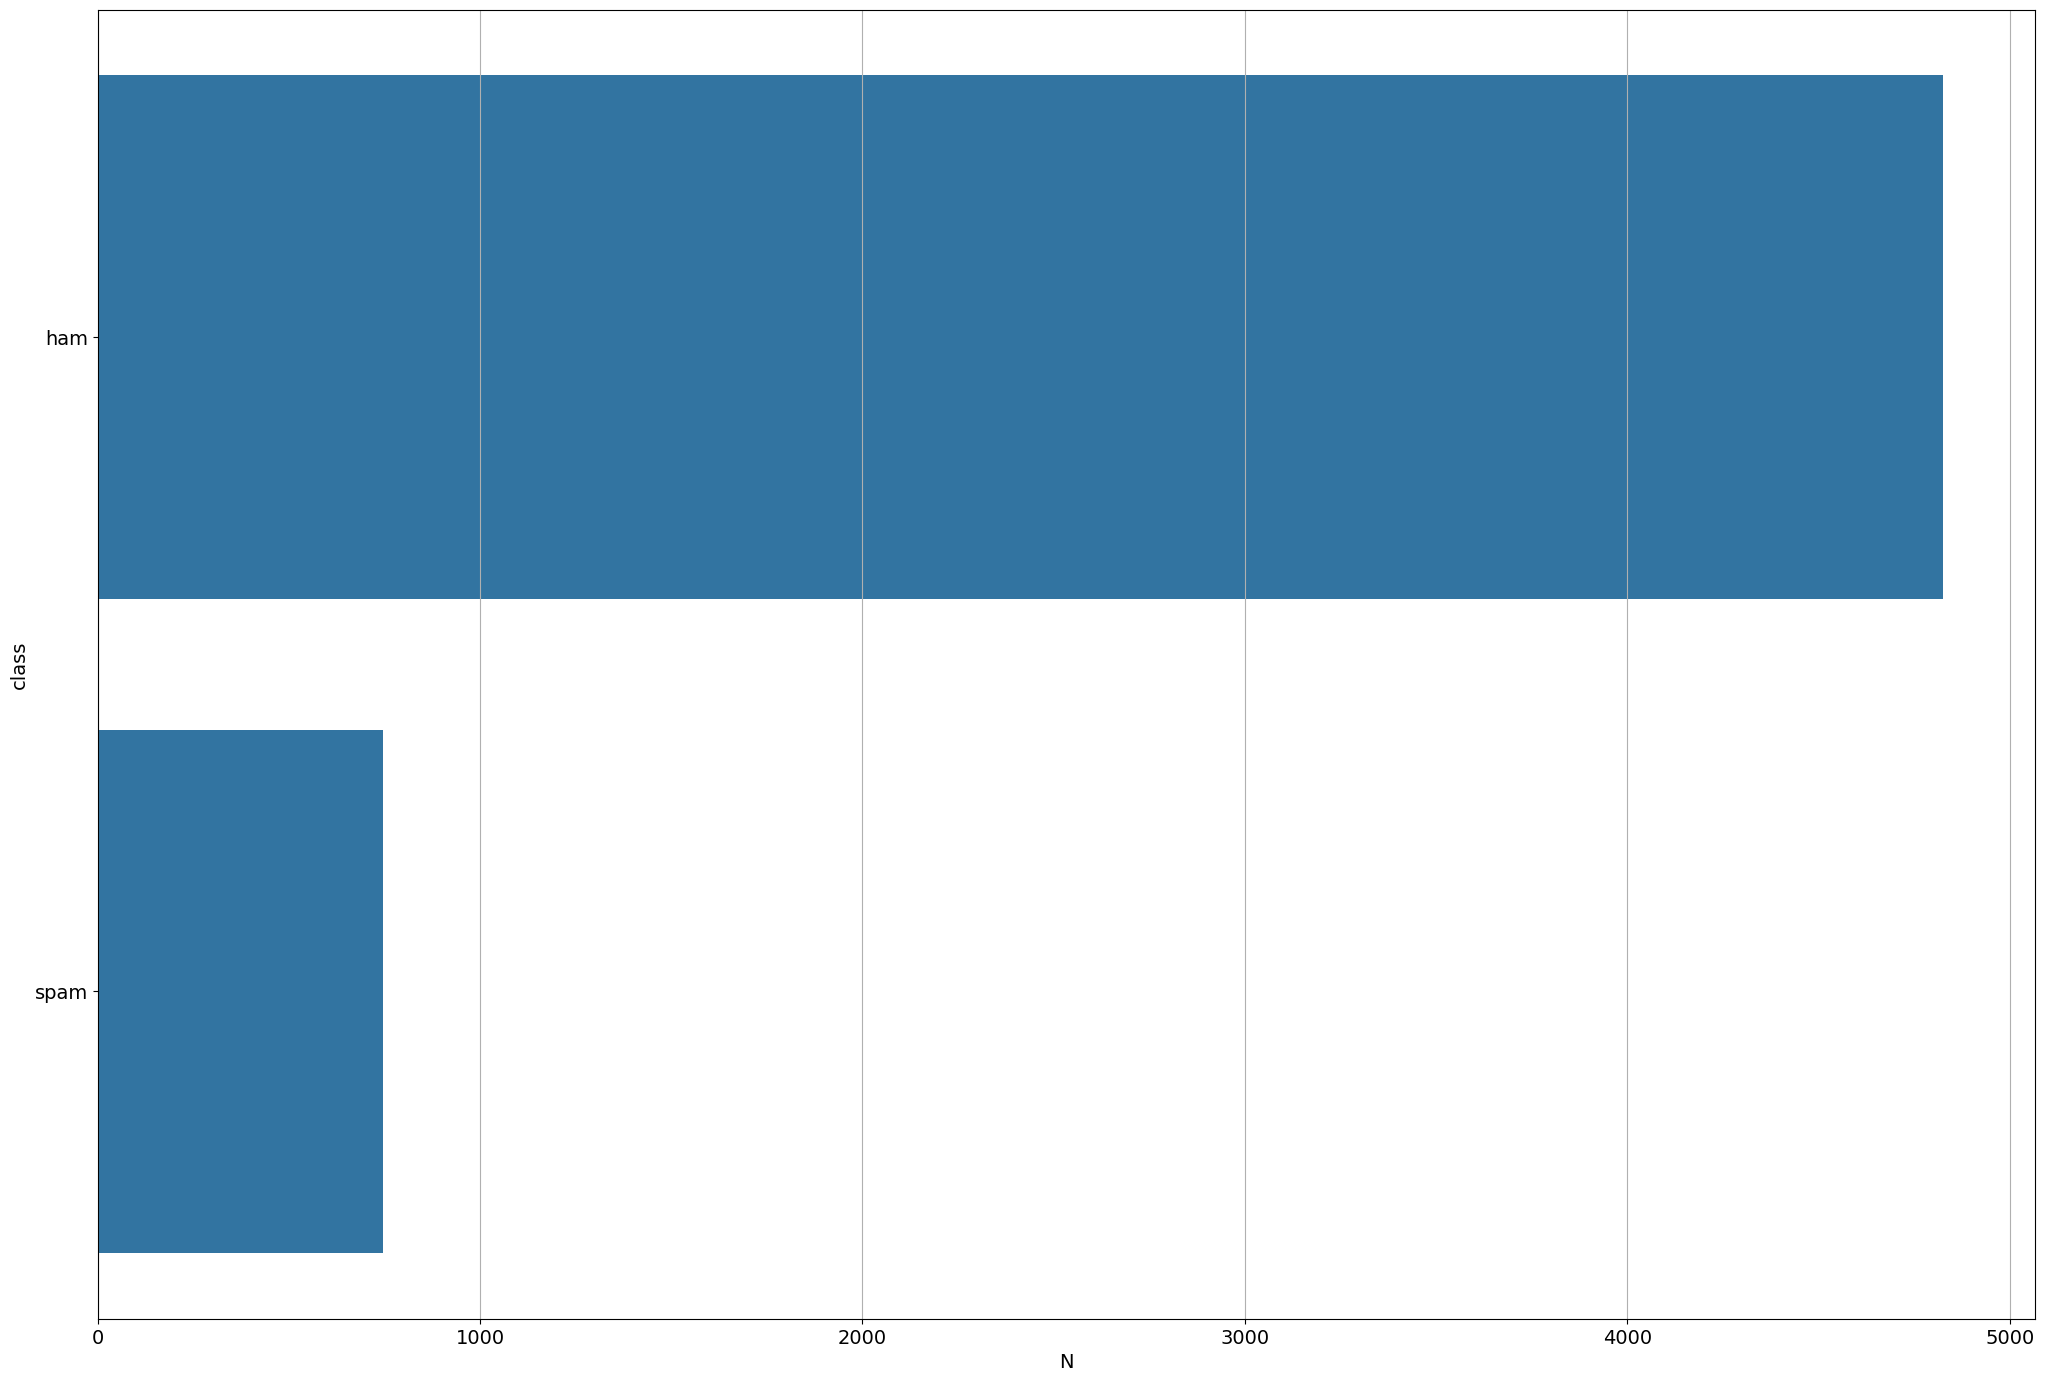

In [143]:
draw_feature_countable("class", sms)

In [144]:
print("Data size: %d" % (len(sms)))

Data size: 5572


#### Преобразование категориальных переменных в числа

In [145]:
sms_text_categories_indexes = {"class": {c: i for i, c in enumerate(sms["class"].unique())}}

In [146]:
sms_text_categories_indexes

{'class': {'ham': 0, 'spam': 1}}

In [147]:
sms["class"].replace(to_replace = sms_text_categories_indexes["class"], inplace = True)

In [148]:
sms.head()

,class,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [149]:
sms.tail()

,class,text
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...
5571,0,Rofl. Its true to its name


#### *One-Hot* преобразование текстов

##### Словарь

In [150]:
def build_vocabulary(texts: List[str]):
	words = list(itertools.chain.from_iterable([text.split() for text in texts]))
	vocab = collections.Counter(words)
	return vocab

In [151]:
texts = sms["text"].tolist()
vocabulary = build_vocabulary(texts)

In [152]:
list(vocabulary.items())[:30]

[('Go', 14),
 ('until', 26),
 ('jurong', 1),
 ('point,', 1),
 ('crazy..', 1),
 ('Available', 3),
 ('only', 147),
 ('in', 800),
 ('bugis', 4),
 ('n', 140),
 ('great', 75),
 ('world', 17),
 ('la', 2),
 ('e', 71),
 ('buffet...', 1),
 ('Cine', 1),
 ('there', 118),
 ('got', 204),
 ('amore', 1),
 ('wat...', 12),
 ('Ok', 97),
 ('lar...', 18),
 ('Joking', 1),
 ('wif', 26),
 ('u', 698),
 ('oni...', 2),
 ('Free', 39),
 ('entry', 25),
 ('2', 457),
 ('a', 1337)]

##### Очистка от специальных символов

In [153]:
def preprocess_text(text: str):
	text = text.lower()
	is_allowed_char = lambda c: c.isalpha() or c == ' '
	text = ''.join(list(filter(is_allowed_char, text)))
	return text

In [154]:
texts = [preprocess_text(text) for text in sms["text"].tolist()]
vocabulary = build_vocabulary(texts)

In [155]:
vocabulary.most_common(30)

[('to', 2251),
 ('i', 2249),
 ('you', 2128),
 ('a', 1448),
 ('the', 1334),
 ('u', 1156),
 ('and', 971),
 ('is', 893),
 ('in', 891),
 ('me', 791),
 ('my', 759),
 ('for', 711),
 ('your', 677),
 ('it', 622),
 ('of', 622),
 ('call', 581),
 ('have', 576),
 ('on', 536),
 ('that', 514),
 ('are', 490),
 ('now', 479),
 ('im', 476),
 ('so', 439),
 ('not', 436),
 ('but', 432),
 ('or', 417),
 ('at', 405),
 ('can', 405),
 ('do', 401),
 ('ur', 390)]

In [156]:
dictionary_str_to_idx: Mapping[str, int] = {}
dictionary_idx_to_str: Mapping[int, str] = {}

In [157]:
for i, s in enumerate(list(vocabulary.keys())):
	dictionary_idx_to_str[i] = s
	dictionary_str_to_idx[s] = i

In [158]:
dictionary_idx_to_str

{0: 'go',
 1: 'until',
 2: 'jurong',
 3: 'point',
 4: 'crazy',
 5: 'available',
 6: 'only',
 7: 'in',
 8: 'bugis',
 9: 'n',
 10: 'great',
 11: 'world',
 12: 'la',
 13: 'e',
 14: 'buffet',
 15: 'cine',
 16: 'there',
 17: 'got',
 18: 'amore',
 19: 'wat',
 20: 'ok',
 21: 'lar',
 22: 'joking',
 23: 'wif',
 24: 'u',
 25: 'oni',
 26: 'free',
 27: 'entry',
 28: 'a',
 29: 'wkly',
 30: 'comp',
 31: 'to',
 32: 'win',
 33: 'fa',
 34: 'cup',
 35: 'final',
 36: 'tkts',
 37: 'st',
 38: 'may',
 39: 'text',
 40: 'receive',
 41: 'questionstd',
 42: 'txt',
 43: 'ratetcs',
 44: 'apply',
 45: 'overs',
 46: 'dun',
 47: 'say',
 48: 'so',
 49: 'early',
 50: 'hor',
 51: 'c',
 52: 'already',
 53: 'then',
 54: 'nah',
 55: 'i',
 56: 'dont',
 57: 'think',
 58: 'he',
 59: 'goes',
 60: 'usf',
 61: 'lives',
 62: 'around',
 63: 'here',
 64: 'though',
 65: 'freemsg',
 66: 'hey',
 67: 'darling',
 68: 'its',
 69: 'been',
 70: 'weeks',
 71: 'now',
 72: 'and',
 73: 'no',
 74: 'word',
 75: 'back',
 76: 'id',
 77: 'like',
 

In [159]:
dictionary_str_to_idx

{'go': 0,
 'until': 1,
 'jurong': 2,
 'point': 3,
 'crazy': 4,
 'available': 5,
 'only': 6,
 'in': 7,
 'bugis': 8,
 'n': 9,
 'great': 10,
 'world': 11,
 'la': 12,
 'e': 13,
 'buffet': 14,
 'cine': 15,
 'there': 16,
 'got': 17,
 'amore': 18,
 'wat': 19,
 'ok': 20,
 'lar': 21,
 'joking': 22,
 'wif': 23,
 'u': 24,
 'oni': 25,
 'free': 26,
 'entry': 27,
 'a': 28,
 'wkly': 29,
 'comp': 30,
 'to': 31,
 'win': 32,
 'fa': 33,
 'cup': 34,
 'final': 35,
 'tkts': 36,
 'st': 37,
 'may': 38,
 'text': 39,
 'receive': 40,
 'questionstd': 41,
 'txt': 42,
 'ratetcs': 43,
 'apply': 44,
 'overs': 45,
 'dun': 46,
 'say': 47,
 'so': 48,
 'early': 49,
 'hor': 50,
 'c': 51,
 'already': 52,
 'then': 53,
 'nah': 54,
 'i': 55,
 'dont': 56,
 'think': 57,
 'he': 58,
 'goes': 59,
 'usf': 60,
 'lives': 61,
 'around': 62,
 'here': 63,
 'though': 64,
 'freemsg': 65,
 'hey': 66,
 'darling': 67,
 'its': 68,
 'been': 69,
 'weeks': 70,
 'now': 71,
 'and': 72,
 'no': 73,
 'word': 74,
 'back': 75,
 'id': 76,
 'like': 77,
 

##### Токенизация

In [160]:
target: List[int] = []
features: List[List[int]] = []

In [161]:
for _, row in sms.iterrows():
	target.append(row["class"])
	feature = [0] * len(dictionary_str_to_idx)
	for w in list(build_vocabulary([preprocess_text(row["text"])]).keys()):
		feature[dictionary_str_to_idx[w]] = 1
	features.append(feature)

#### Деление на `train`, `test` множества

In [162]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE)

### Алгоритмы

In [163]:
class Searcher(ABC):
	@abstractmethod
	def search(self, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
		return []

In [164]:
def sliced(xs: List[List[int]], idx: List[int]) -> List[List[int]]:
	return [[y[i] for i in idx] for y in xs]

In [165]:
def sliced1(xs: List[List[int]], idx: int) -> List[List[int]]:
	return [y[idx] for y in xs]

In [166]:
def index_max(xs: list) -> int:
	max_index = 0
	for i in range(len(xs)):
		if xs[i] > xs[max_index]:
			max_index = i
	return max_index

In [167]:
def firstN(xs: list, n: int) -> list:
	return [x for i, x in enumerate(xs) if i < n]

In [168]:
def lastN(xs: list, n: int) -> list:
	if n >= len(xs): return xs
	else: return xs[-n:]

In [169]:
def remove_by_indexes(xs: list, indexes: List[int]) -> list:
	idx = set(indexes)
	nxs = []
	for i, x in enumerate(xs):
		if i not in idx:
			nxs.append(x)
	return nxs

#### Встроенный метод выбора признаков

In [170]:
class EmbeddedFeatureSearcher(Searcher):
	def __init__(self, n_max_features: int, step: float, criterion: str = "entropy", max_depth: int = 10, min_samples_leaf: int = 100):
		self.__n_max_features = n_max_features
		self.__step = step
		self.__algorithm = sklearn.tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

	def search(self, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
		selected_features = copy.deepcopy(features)

		while (len(selected_features)) > self.__n_max_features:
			next_step = int(self.__step * len(selected_features))
			new_X = sliced(X, selected_features)
			self.__algorithm.fit(new_X, y)
			important_features = self.__algorithm.feature_importances_.tolist()
			bad_features = numpy.argsort(important_features)
			selected_features = remove_by_indexes(selected_features, firstN(bad_features, next_step))

		return selected_features

#### Метод-обёртки выбора признаков

In [171]:
class WrapperFeatureSearcher(Searcher):
	def __init__(self, n_max_features: int, criterion: str = "entropy", max_depth: int = 10, min_samples_leaf: int = 100):
		self.__n_max_features = n_max_features
		self.__algorithm = sklearn.tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

	def search(self, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
		selected_features: List[int] = []
		selected_features_set: Set[int] = set()

		while len(selected_features) < self.__n_max_features:
			scores: List[float] = []

			for feature in features:
				if feature not in selected_features_set:
					new_features = selected_features + [feature]
					new_X = sliced(X, new_features)
					self.__algorithm.fit(new_X, y)
					scores.append(self.__algorithm.score(new_X, y))
				else:
					scores.append(-float("inf"))

			best_feature = index_max(scores)
			selected_features.append(best_feature)
			selected_features_set.add(best_feature)

			print("%d/%d" % (len(selected_features), self.__n_max_features))

		return selected_features

#### Фильтрующий метод выбора признаков

In [172]:
def get_correlation(X: List[int], y: List[int]) -> float:
	n = len(X)
	sumx = sum(X)
	sumy = sum(y)
	sumx_squared = sum(x ** 2 for x in X)
	sumy_squared = sum(y ** 2 for y in y)
	sum_xy = sum(x * y for x, y in zip(X, y))

	numerator = n * sum_xy - sumx * sumy
	denominator = math.sqrt((n * sumx_squared - sumx ** 2) * (n * sumy_squared - sumy ** 2))

	if denominator == 0:
		return 0.0
	else:
		return numerator / denominator


In [173]:
class FilterFeatureSearcher(Searcher):
	def __init__(self, n_max_features: int):
		self.__n_max_features = n_max_features

	def search(self, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
		correlations: List[float] = []

		for feature in features:
			new_X = sliced1(X, feature)
			corr, _ = scipy.stats.pearsonr(new_X, y)
			if not math.isnan(corr):
				correlations.append(abs(corr))

		selected_features = numpy.argsort(correlations)
		return lastN(selected_features, self.__n_max_features)

#### Библиотечные методы

In [174]:
class KBestWrapper(Searcher):
	def __init__(self, n_max_features: int):
		self.__n_max_features = n_max_features

	def search(self, X: List[List[int]], y: List[int], _: List[int]) -> List[int]:
		selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.chi2, k = self.__n_max_features)
		selector.fit(X, y)
		return selector.get_support(indices = True)

In [175]:
class VarianceSearcherWrapper(Searcher):
	def __init__(self):
		pass

	def search(self, X: List[List[int]], y: List[int], _: List[int]) -> List[int]:
		selector = sklearn.feature_selection.VarianceThreshold()
		selector.fit(X, y)
		return selector.get_support(indices = True)

In [176]:
class TreeSearcherWrapper(Searcher):
	def __init__(self, n_max_features: int, criterion: str = "entropy", max_depth: int = 10, min_samples_leaf: int = 100):
		self.__n_max_features = n_max_features
		self.__algorithm = sklearn.tree.DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

	def search(self, X: List[List[int]], y: List[int], _: List[int]) -> List[int]:
		self.__algorithm.fit(X, y)
		selector = sklearn.feature_selection.SelectFromModel(self.__algorithm, max_features = self.__n_max_features)
		return selector.get_support(indices = True)

### Исследования

In [177]:
features = list(range(len(features[0])))
N_INDEXES = 30

#### Самописный vs. библиотечный

In [178]:
def draw_diffs_vs_library(param_name: str, diffs: List[List[float]], diff_names: List[str], params: Union[List[int], List[float]]):
	title = "Исследование разницы самописного метода и библиотечного от гиперпараметра"
	xlabel = param_name
	ylabel = "Разница методов (в %)"
	matplotlib.pyplot.figure(figsize = MATPLOTLIB_PYPLOT_FIGSIZE)
	matplotlib.pyplot.title(title)
	for diff, name in zip(diffs, diff_names):
		matplotlib.pyplot.plot(params, diff, label = name)
	matplotlib.pyplot.xlabel(xlabel)
	matplotlib.pyplot.ylabel(ylabel)
	matplotlib.pyplot.legend()
	matplotlib.pyplot.show()

In [179]:
def get_error(actual: List[int], expected: List[int]) -> float:
	correct = 0
	for x in expected:
		if x in actual:
			correct += 1
	return correct / len(expected)

In [180]:
def get_diff(X: List[List[int]], y: List[int], features: List[int], impl: Searcher, lib: Searcher, n_indexes: int) -> float:
	lib_indexes = lib.search(X, y, features)[:n_indexes]
	impl_indexes = impl.search(X, y, features)[:n_indexes]
	return (1.0 - get_error(impl_indexes, lib_indexes)) * 100.0

##### Высота дерева

In [181]:
n_max_features = 100
step = 0.25

In [182]:
params = list(range(1, 20))
param_name = "Высота дерева"

In [183]:
diffs: List[List[float]] = [] * len(params)
diff_names: List[str] = []

In [184]:
# EmbeddedFeatureSearcher vs. KBestWrapper
diff_names.append("Встроенный метод vs. SelectKBest")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = EmbeddedFeatureSearcher(n_max_features = n_max_features, step = step, max_depth = param)
	lib = KBestWrapper(n_max_features = n_max_features)
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 19/19 [02:41<00:00,  8.52s/it]


In [185]:
# EmbeddedFeatureSearcher vs. VarianceSearcherWrapper
diff_names.append("Встроенный метод vs. VarianceThreshold")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = EmbeddedFeatureSearcher(n_max_features = n_max_features, step = step, max_depth = param)
	lib = VarianceSearcherWrapper()
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 19/19 [02:43<00:00,  8.61s/it]


In [186]:
# EmbeddedFeatureSearcher vs. TreeSearcherWrapper
diff_names.append("Встроенный метод vs. основанный на деревьях")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = EmbeddedFeatureSearcher(n_max_features = n_max_features, step = step, max_depth = param)
	lib = TreeSearcherWrapper(n_max_features = n_max_features, max_depth = param)
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 19/19 [02:53<00:00,  9.14s/it]


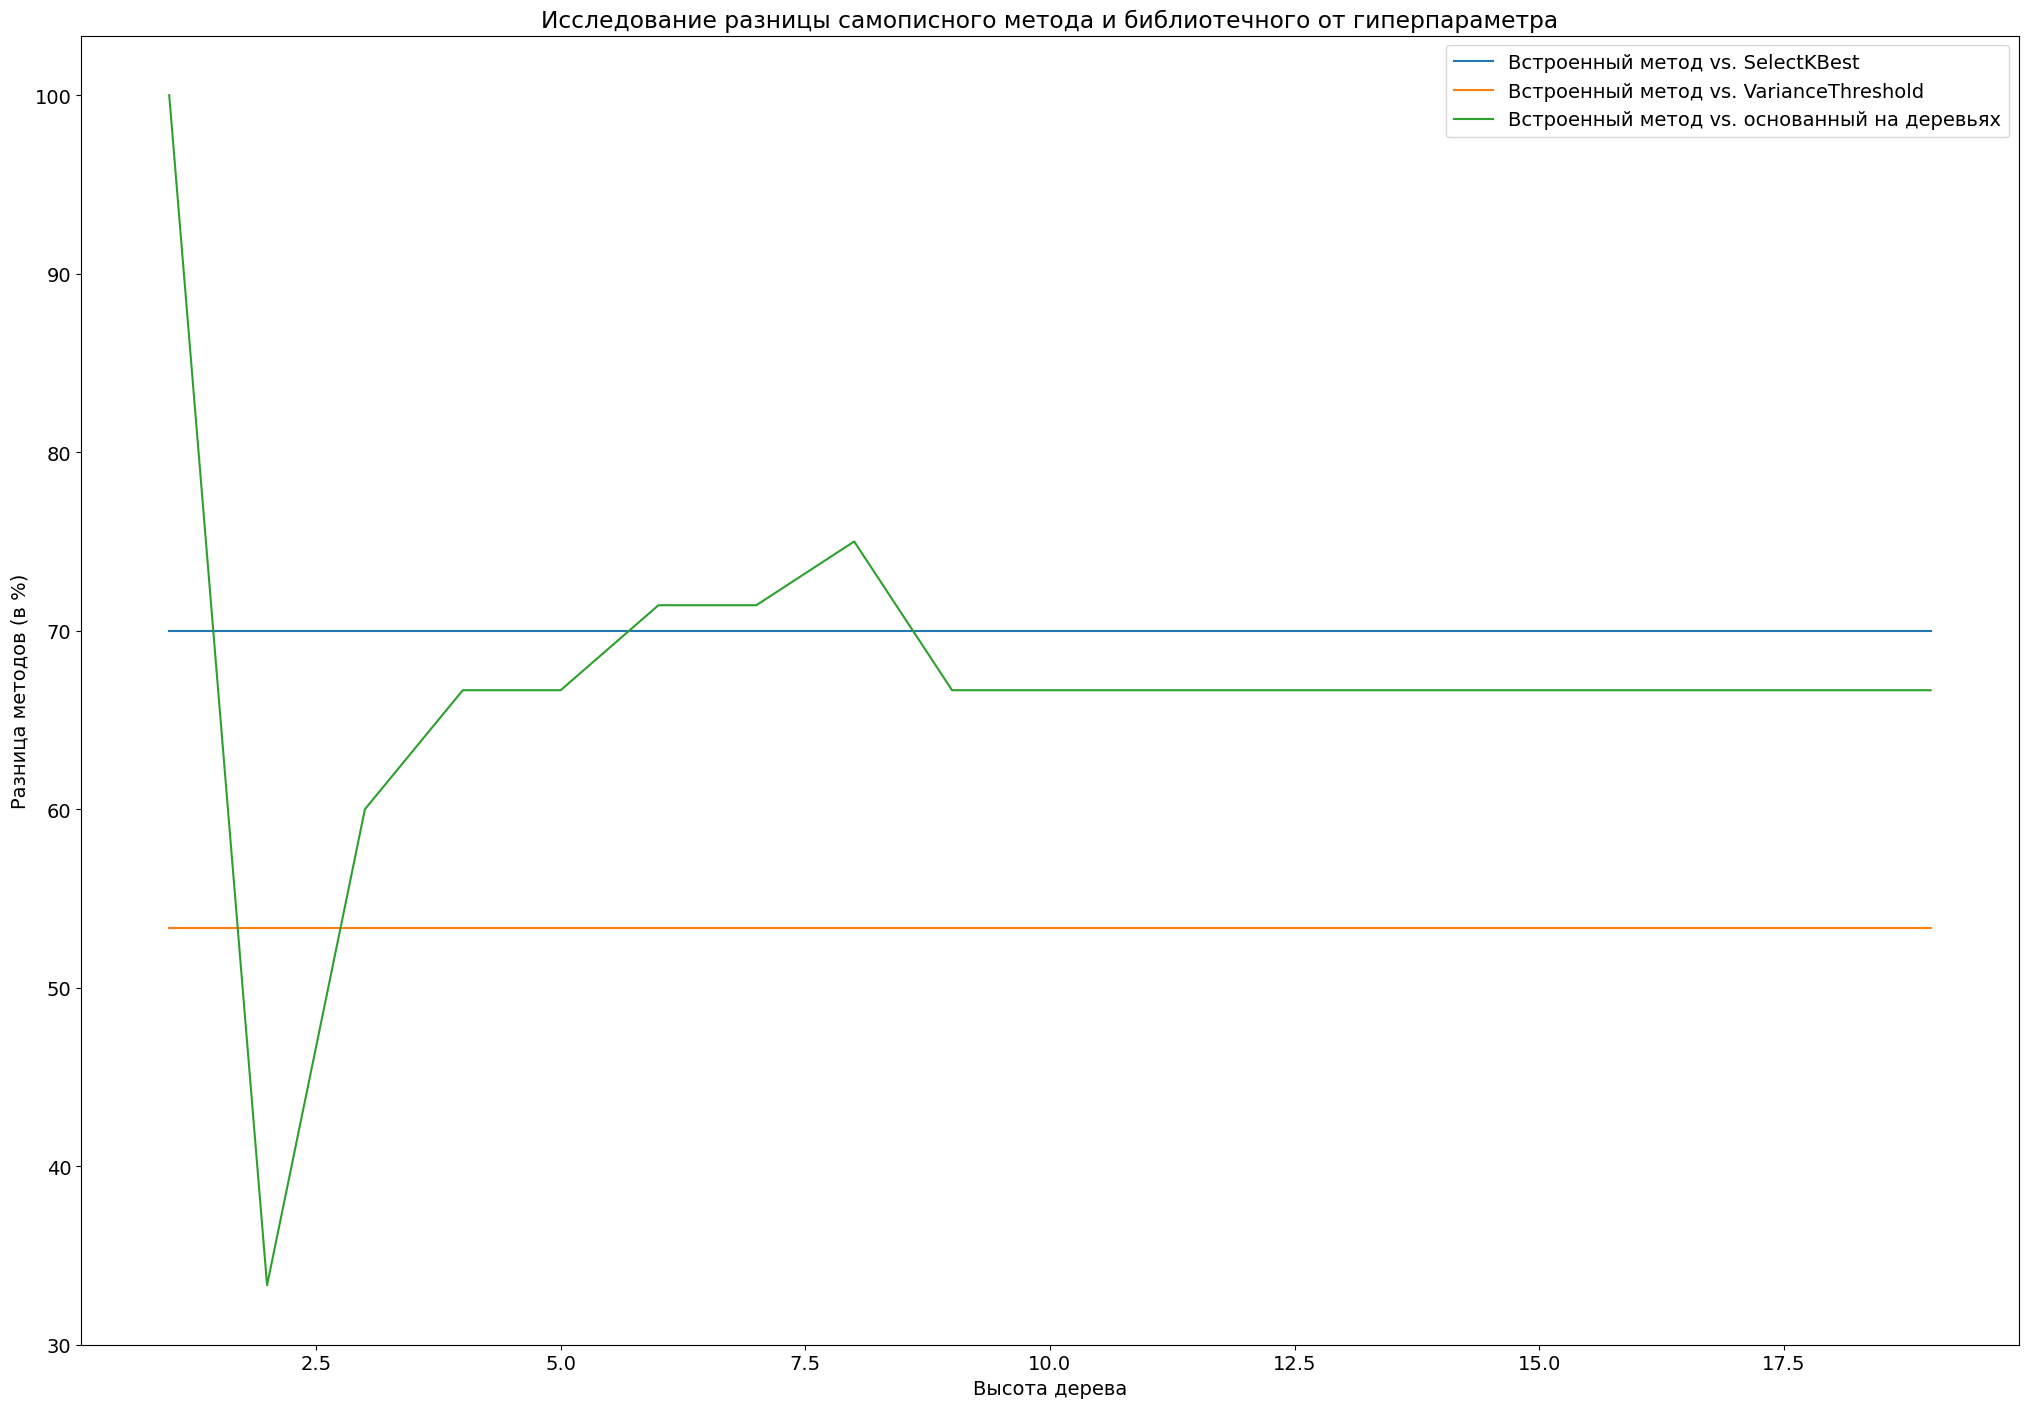

In [187]:
draw_diffs_vs_library(param_name, diffs, diff_names, params)

##### Максимальное количество признаков

In [188]:
step = 0.25

In [189]:
params = list(range(50, 250, 10))
param_name = "Максимальное количество признаков"

In [190]:
diffs: List[List[float]] = [] * len(params)
diff_names: List[str] = []

In [191]:
# FilterFeatureSearcher vs. KBestWrapper
diff_names.append("Фильтрующий метод vs. SelectKBest")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = FilterFeatureSearcher(n_max_features = n_max_features)
	lib = KBestWrapper(n_max_features = n_max_features)
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


In [192]:
# FilterFeatureSearcher vs. VarianceSearcherWrapper
diff_names.append("Фильтрующий метод vs. VarianceThreshold")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = FilterFeatureSearcher(n_max_features = n_max_features)
	lib = VarianceSearcherWrapper()
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


In [193]:
# FilterFeatureSearcher vs. TreeSearcherWrapper
diff_names.append("Фильтрующий метод vs. основанный на деревьях")
diff_tmp: List[float] = []
for param in tqdm.tqdm(params):
	impl = FilterFeatureSearcher(n_max_features = n_max_features)
	lib = TreeSearcherWrapper(n_max_features = n_max_features, max_depth = param)
	diff_tmp.append(get_diff(X_train, y_train, features, impl, lib, N_INDEXES))
diffs.append(diff_tmp)

100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


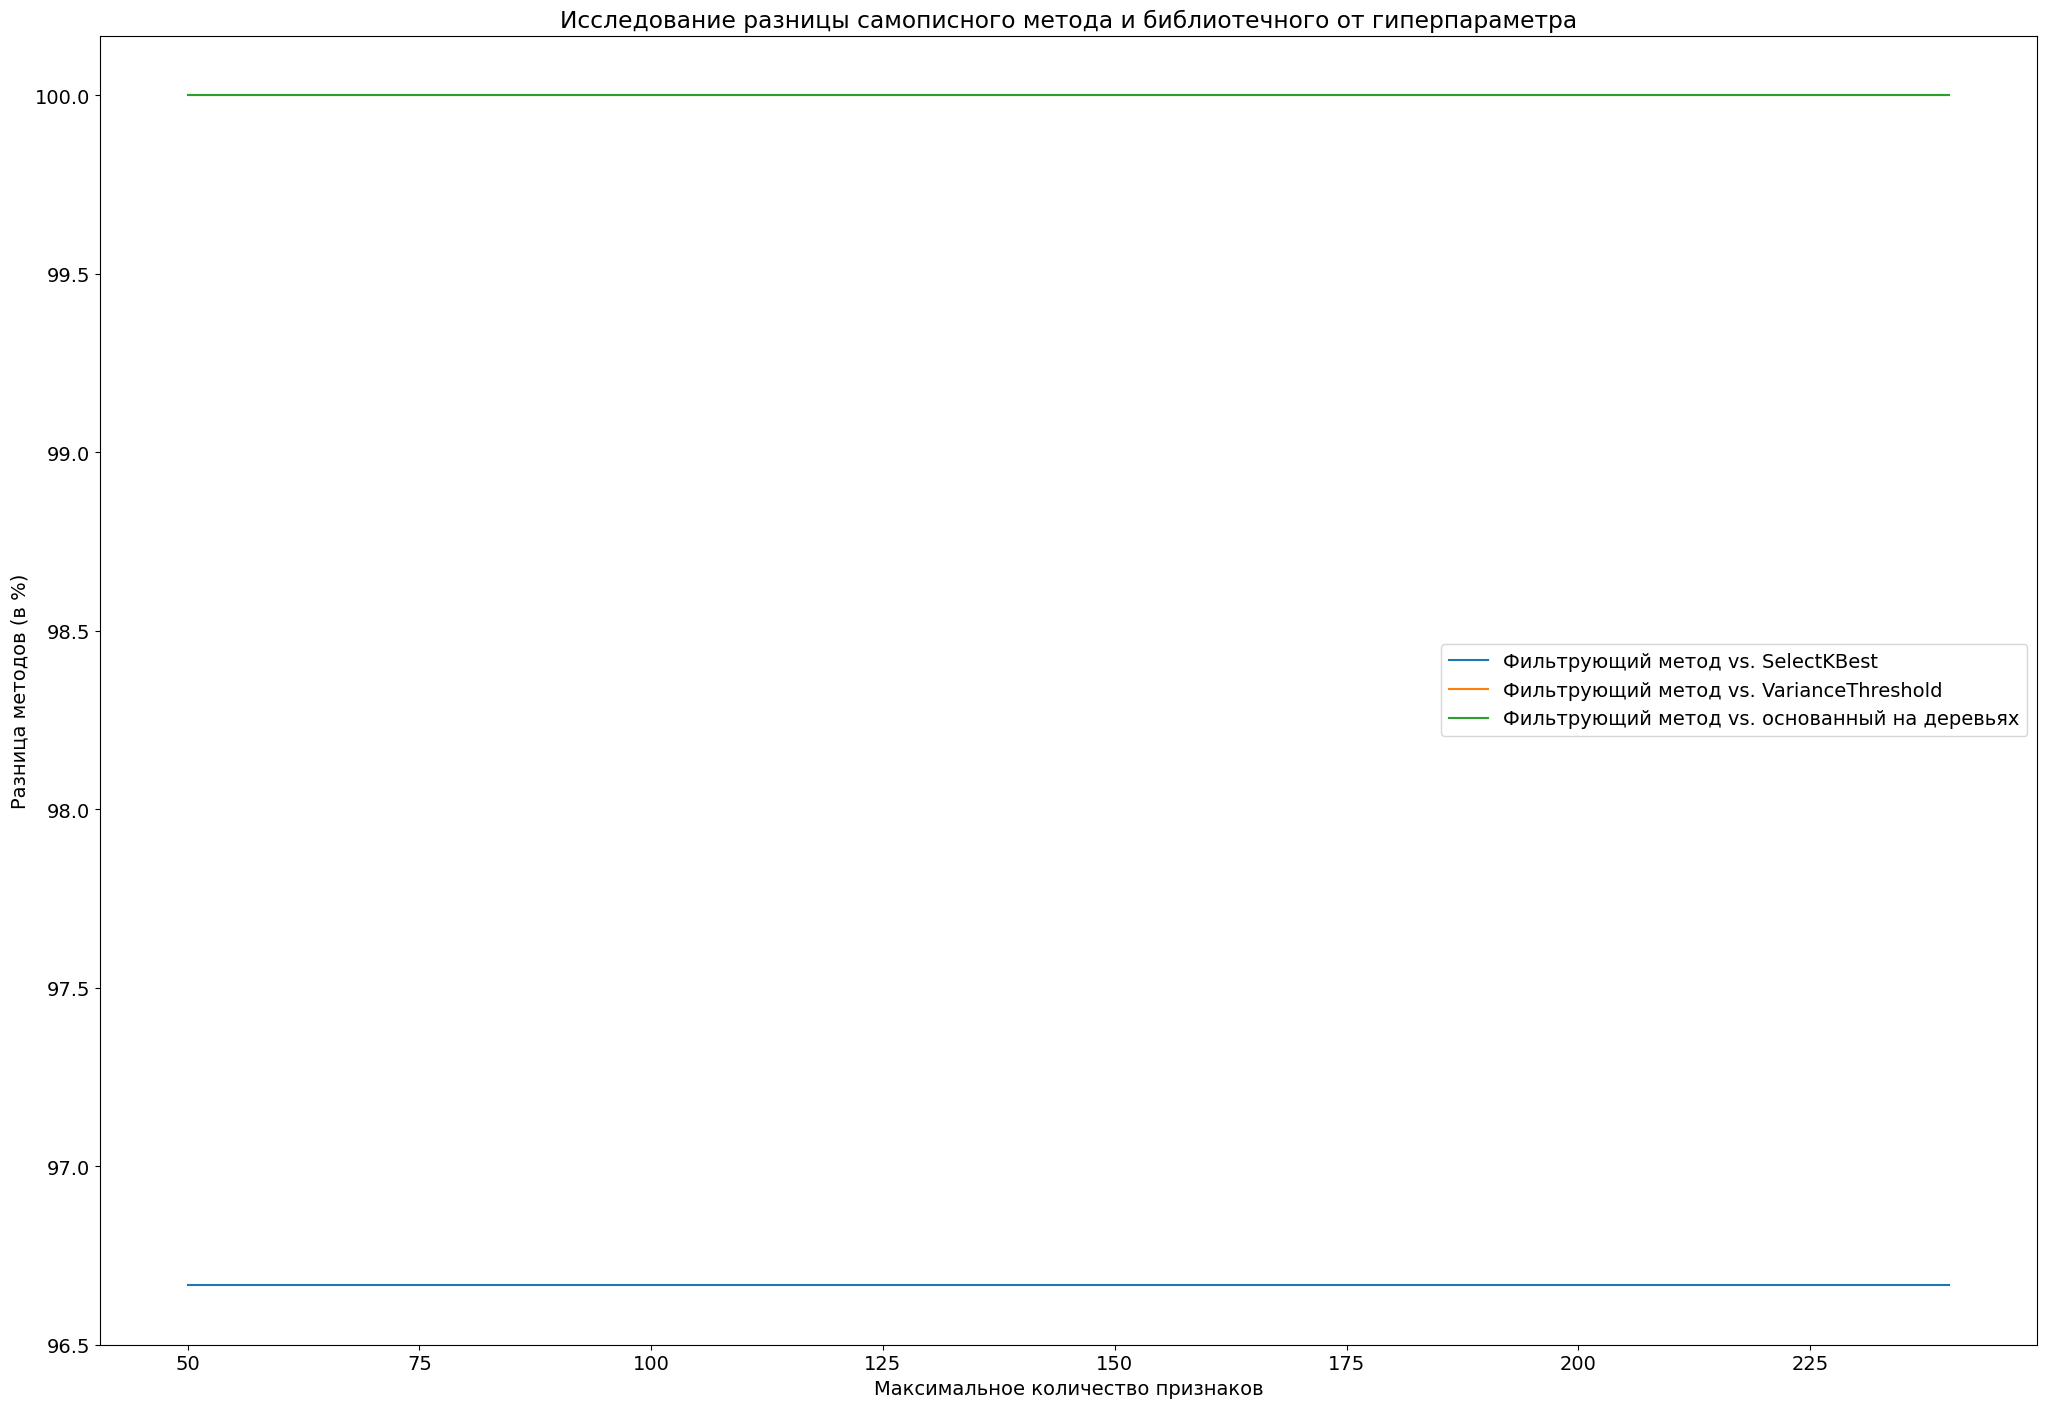

In [194]:
draw_diffs_vs_library(param_name, diffs, diff_names, params)

##### Без параметров

In [195]:
n_max_features = 50

In [196]:
model_implementation = WrapperFeatureSearcher(n_max_features = n_max_features)
model_library = KBestWrapper(n_max_features = n_max_features)
indexes_implementation = model_implementation.search(X_train, y_train, features)[:N_INDEXES]
indexes_library = model_library.search(X_train, y_train, None)[:N_INDEXES]

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


In [197]:
print("Процент совпадения при методе-обёртке с SelectKBest: %d%%" % (get_error(indexes_implementation, indexes_library) * 100.0))

Процент совпадения при методе-обёртке с SelectKBest: 3%


#### Ограниченный набор признаков

In [198]:
model_1 = sklearn.tree.DecisionTreeClassifier()
model_2 = sklearn.ensemble.AdaBoostClassifier()
model_3 = sklearn.ensemble.RandomForestClassifier()

In [199]:
step = 0.25
n_max_features = 250

##### Встроенный метод выбора признаков

In [200]:
def embedded_features(model, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
	selected_features = copy.deepcopy(features)

	while (len(selected_features)) > n_max_features:
		next_step = int(step * len(selected_features))
		new_X = sliced(X, selected_features)
		model.fit(new_X, y)
		important_features = model.feature_importances_.tolist()
		bad_features = numpy.argsort(important_features)
		selected_features = remove_by_indexes(selected_features, firstN(bad_features, next_step))

	return selected_features

In [201]:
selector = {
    "дерево принятия решения" : model_1,
    "бустинг" : model_2,
    "случайный лес" : model_3,
}

In [202]:
for n, m in selector.items():
	selected = embedded_features(m, X_train, y_train, features)

	X_train_original = X_train
	X_train_selected = sliced(X_train, selected)
	X_test_original = X_test
	X_test_selected = sliced(X_test, selected)

	# Original indexes.
	m.fit(X_train_original, y_train)
	predicted_original = m.predict(X_test_original)
	score_original = sklearn.metrics.accuracy_score(y_test, predicted_original)

	# Selected indexes.
	m.fit(X_train_selected, y_train)
	predicted_selected = m.predict(X_test_selected)
	score_selected = sklearn.metrics.accuracy_score(y_test, predicted_selected)

	# Output.
	print("Классификатор, именуемый как %s выдаёт точность %d%% при всех признаках и %d%% при выбранных." % (n, score_original * 100.0, score_selected * 100.0))

Классификатор, именуемый как дерево принятия решения выдаёт точность 96% при всех признаках и 96% при выбранных.
Классификатор, именуемый как бустинг выдаёт точность 96% при всех признаках и 96% при выбранных.
Классификатор, именуемый как случайный лес выдаёт точность 97% при всех признаках и 98% при выбранных.


##### Метод-обёртки выбора признаков

In [206]:
n_max_features = 10

In [207]:
def wrapper_features(model, X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
	selected_features: List[int] = []
	selected_features_set: Set[int] = set()

	while len(selected_features) < n_max_features:
		scores: List[float] = []

		for feature in features:
			if feature not in selected_features_set:
				new_features = selected_features + [feature]
				new_X = sliced(X, new_features)
				model.fit(new_X, y)
				scores.append(model.score(new_X, y))
			else:
				scores.append(-float("inf"))

		best_feature = index_max(scores)
		selected_features.append(best_feature)
		selected_features_set.add(best_feature)

		print("%d/%d" % (len(selected_features), n_max_features))

	return selected_features

In [209]:
for n, m in selector.items():
	selected = wrapper_features(m, X_train, y_train, features)

	X_train_original = X_train
	X_train_selected = sliced(X_train, selected)
	X_test_original = X_test
	X_test_selected = sliced(X_test, selected)

	# Original indexes.
	m.fit(X_train_original, y_train)
	predicted_original = m.predict(X_test_original)
	score_original = sklearn.metrics.accuracy_score(y_test, predicted_original)

	# Selected indexes.
	m.fit(X_train_selected, y_train)
	predicted_selected = m.predict(X_test_selected)
	score_selected = sklearn.metrics.accuracy_score(y_test, predicted_selected)

	# Output.
	print("Классификатор, именуемый как %s выдаёт точность %d%% при всех признаках и %d%% при выбранных." % (n, score_original * 100.0, score_selected * 100.0))

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
Классификатор, именуемый как дерево принятия решения выдаёт точность 96% при всех признаках и 95% при выбранных.
1/10
2/10
3/10
4/10
5/10
6/10
7/10


KeyboardInterrupt: 

##### Фильтрующий метод выбора признаков

In [203]:
n_max_features = 250

In [204]:
def filter_features(X: List[List[int]], y: List[int], features: List[int]) -> List[int]:
	correlations: List[float] = []

	for feature in features:
		new_X = sliced1(X, feature)
		corr, _ = scipy.stats.pearsonr(new_X, y)
		if not math.isnan(corr):
			correlations.append(abs(corr))

	selected_features = numpy.argsort(correlations)
	return lastN(selected_features, n_max_features)

In [205]:
for n, m in selector.items():
	selected = filter_features(X_train, y_train, features)

	X_train_original = X_train
	X_train_selected = sliced(X_train, selected)
	X_test_original = X_test
	X_test_selected = sliced(X_test, selected)

	# Original indexes.
	m.fit(X_train_original, y_train)
	predicted_original = m.predict(X_test_original)
	score_original = sklearn.metrics.accuracy_score(y_test, predicted_original)

	# Selected indexes.
	m.fit(X_train_selected, y_train)
	predicted_selected = m.predict(X_test_selected)
	score_selected = sklearn.metrics.accuracy_score(y_test, predicted_selected)

	# Output.
	print("Классификатор, именуемый как %s выдаёт точность %d%% при всех признаках и %d%% при выбранных." % (n, score_original * 100.0, score_selected * 100.0))

Классификатор, именуемый как дерево принятия решения выдаёт точность 96% при всех признаках и 95% при выбранных.
Классификатор, именуемый как бустинг выдаёт точность 96% при всех признаках и 96% при выбранных.
Классификатор, именуемый как случайный лес выдаёт точность 97% при всех признаках и 97% при выбранных.
